In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K
import tensorflow as tf

In [16]:
print(f"TensorFlow versão: {tf.__version__}")

TensorFlow versão: 2.12.0


In [17]:
# 1. Preparar o dataset Fashion MNIST em pares
def create_pairs(x, y, num_classes=10):
    """Cria pares de imagens com seus rótulos de similaridade"""
    pairs = []
    labels = []
    
    # Organizar imagens por classe
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    # Criar pares positivos e negativos
    for idx in range(len(x)):
        # Par positivo (mesma classe)
        current_class = int(y[idx])  # Converter para int
        positive_idx = np.random.choice(digit_indices[current_class])
        pairs.append([x[idx], x[positive_idx]])
        labels.append(1)
        
        # Par negativo (classes diferentes)
        negative_class = np.random.choice([i for i in range(num_classes) if i != current_class])
        negative_idx = np.random.choice(digit_indices[negative_class])
        pairs.append([x[idx], x[negative_idx]])
        labels.append(0)
    
    return np.array(pairs), np.array(labels)

# Carregar e preparar dados
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizar e adicionar dimensão do canal
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Criando pares de treinamento...")
train_pairs, train_labels = create_pairs(x_train, y_train)
print("Criando pares de teste...")
test_pairs, test_labels = create_pairs(x_test, y_test)

print(f"Formato dos pares de treino: {train_pairs.shape}")
print(f"Formato dos rótulos de treino: {train_labels.shape}")

Criando pares de treinamento...
Criando pares de teste...
Formato dos pares de treino: (120000, 2, 28, 28, 1)
Formato dos rótulos de treino: (120000,)


In [18]:
# 2. Definir o modelo base
def create_base_network(input_shape):
    """Cria a rede base que será compartilhada"""
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(128)(x)  # Vetor de saída
    
    return Model(input_layer, output)

In [19]:
# 3. Implementar a camada de distância euclidiana
def euclidean_distance(vectors):
    """Calcula a distância euclidiana entre dois vetores"""
    vector1, vector2 = vectors
    sum_squared = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [20]:
# 4. Implementar a Contrastive Loss
def contrastive_loss(margin=1.0):
    """Função de perda contrastiva"""
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean((1 - y_true) * square_pred + y_true * margin_square)
    return loss

# Criar o modelo siamês
input_shape = (28, 28, 1)
base_network = create_base_network(input_shape)

# Entradas para as duas imagens
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

# Processar ambas as imagens com a mesma rede
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Calcular distância euclidiana
distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])

# Criar modelo siamês
siamese_model = Model(inputs=[input_a, input_b], outputs=distance)

# Compilar modelo
siamese_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=contrastive_loss(margin=1.0),
    metrics=['accuracy']
)

print("\nResumo do Modelo Base:")
base_network.summary()

print("\nResumo do Modelo Siamês:")
siamese_model.summary()

# Treinar o modelo
print("\nTreinando o modelo...")
history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], 
    train_labels,
    batch_size=128,
    epochs=20,
    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels),
    verbose=1
)


Resumo do Modelo Base:
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None,

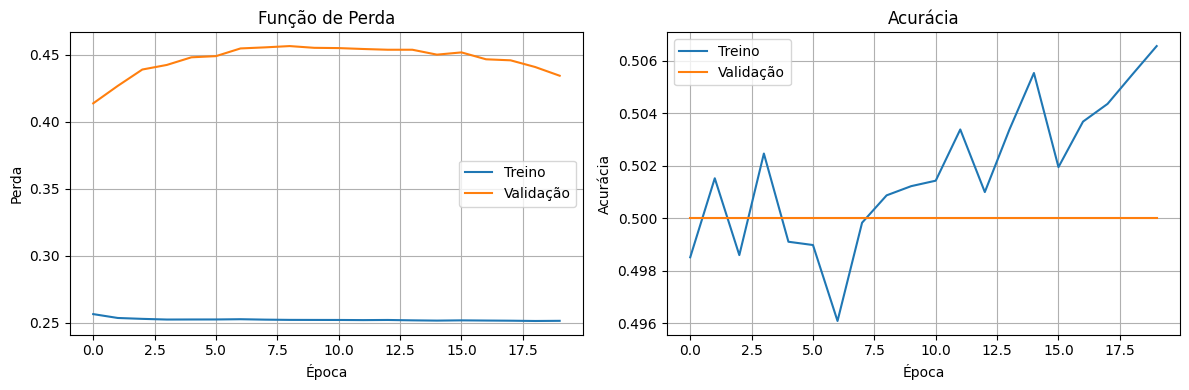

In [21]:
# 5. Visualizar comportamento da função de perda
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Função de Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()


Visualizando predições...


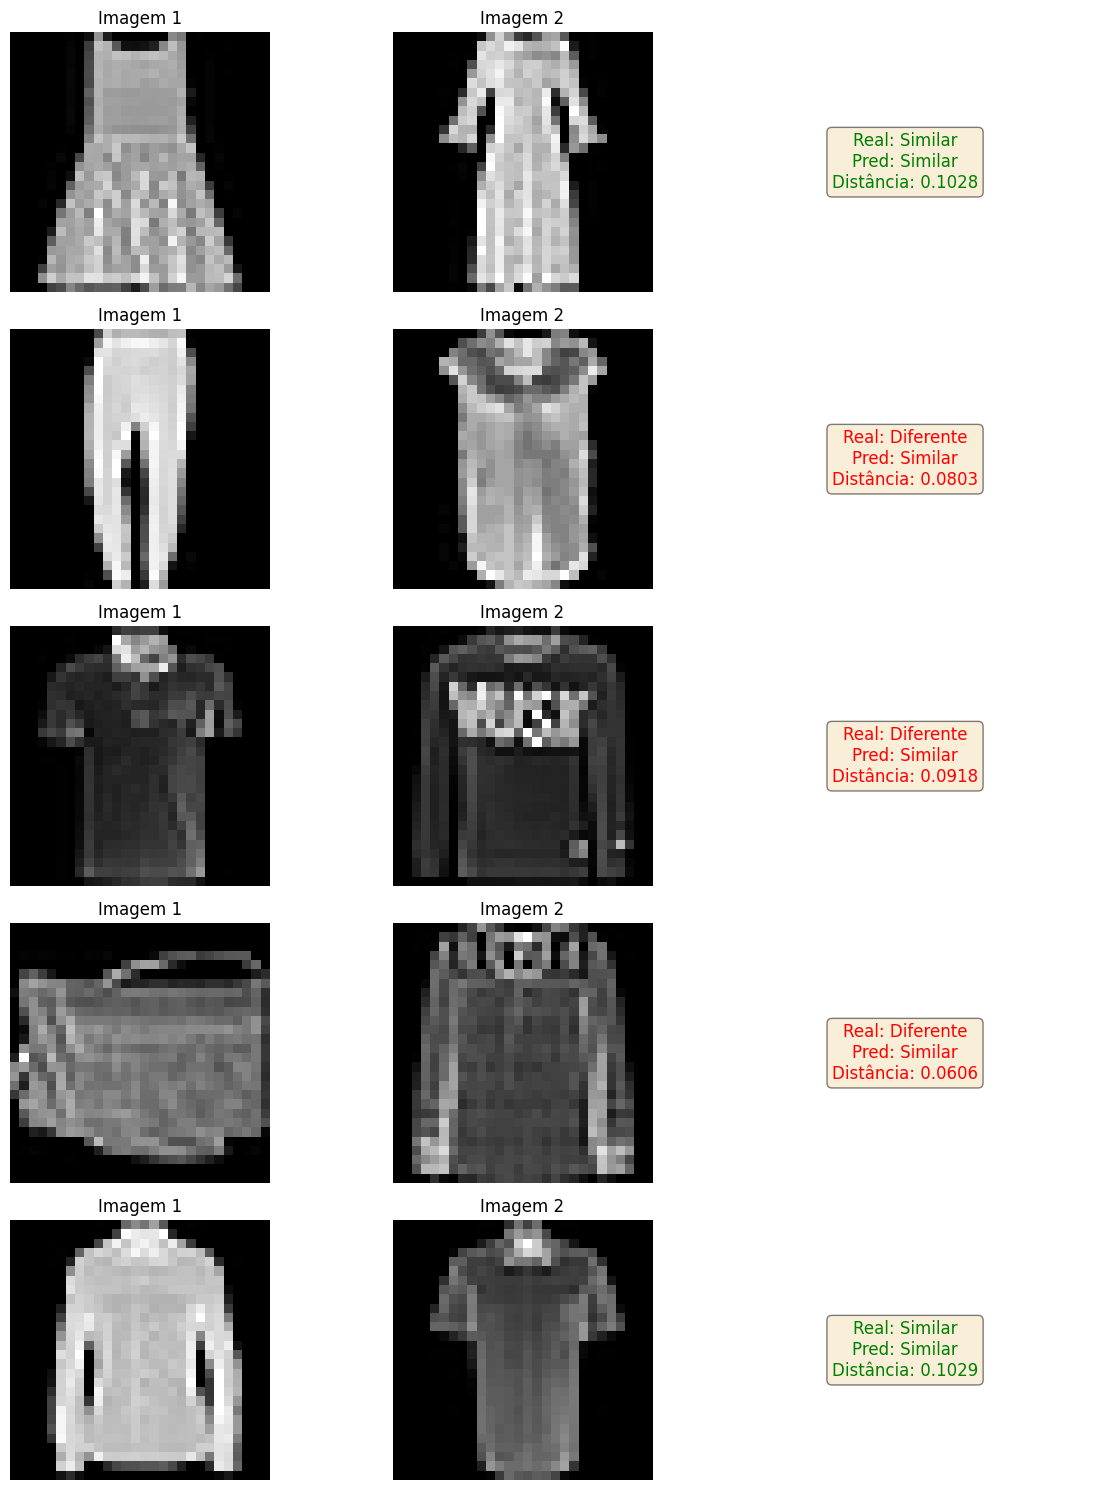


Salvando modelos...


Modelos salvos: base_network_model.h5 e siamese_model.h5

Avaliando modelo no conjunto de teste...
Perda no teste: 0.4342
Acurácia no teste: 0.5000


In [22]:
# 6. Visualizar resultados do modelo
def visualize_predictions(model, pairs, labels, n_samples=5):
    """Visualiza predições do modelo"""
    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 3*n_samples))
    
    indices = np.random.choice(len(pairs), n_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img1 = pairs[idx, 0]
        img2 = pairs[idx, 1]
        true_label = labels[idx]
        
        # Fazer predição
        pred_distance = model.predict([
            np.expand_dims(img1, 0),
            np.expand_dims(img2, 0)
        ], verbose=0)[0][0]
        
        pred_label = 1 if pred_distance < 0.5 else 0
        
        # Plotar imagens
        axes[i, 0].imshow(img1.squeeze(), cmap='gray')
        axes[i, 0].set_title('Imagem 1')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img2.squeeze(), cmap='gray')
        axes[i, 1].set_title('Imagem 2')
        axes[i, 1].axis('off')
        
        # Informações
        color = 'green' if pred_label == true_label else 'red'
        info_text = f"Real: {'Similar' if true_label == 1 else 'Diferente'}\n"
        info_text += f"Pred: {'Similar' if pred_label == 1 else 'Diferente'}\n"
        info_text += f"Distância: {pred_distance:.4f}"
        
        axes[i, 2].text(0.5, 0.5, info_text, 
                       ha='center', va='center', 
                       fontsize=12, color=color,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('model_predictions.png', dpi=150)
    plt.show()

print("\nVisualizando predições...")
visualize_predictions(siamese_model, test_pairs, test_labels, n_samples=5)

# Salvar modelos
print("\nSalvando modelos...")
base_network.save('base_network_model.h5')
siamese_model.save('siamese_model.h5')
print("Modelos salvos: base_network_model.h5 e siamese_model.h5")

# Avaliar modelo
print("\nAvaliando modelo no conjunto de teste...")
test_loss, test_acc = siamese_model.evaluate(
    [test_pairs[:, 0], test_pairs[:, 1]], 
    test_labels,
    verbose=0
)
print(f"Perda no teste: {test_loss:.4f}")
print(f"Acurácia no teste: {test_acc:.4f}")